In [1]:
import os
import pickle

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import sys
import pandas as pd
#import tensorflow
#import keras
import wordcloud
import nltk
import inspect
import re
import unicodedata

nltk.download('stopwords')

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import RSLPStemmer #Stemmer for portugese words.

from nltk.probability import FreqDist
from collections import defaultdict
from heapq import nlargest
stop = stopwords.words('portuguese')
stop.append('nao') #Stopword already have "Não", just adding this because it's appear on dataframe

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\d.cadavid141\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
#import missingno as msno
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
import string
import sys
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csr_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,roc_curve
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import time
import sys
import math
import itertools
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#import folium
#from folium.plugins import Fullscreen
#import geopandas as gpd
import json
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [5]:
os.getcwd()

'C:\\Users\\d.cadavid141\\Documents\\Coisas Daniela\\201920\\201920\\03_Codigos'

In [6]:
#os.chdir("/Users/danielacadavid/Documents/Universidad/Maestria/201920/00_Bases/brazilian-ecommerce/")
os.chdir("C:\\Users\\d.cadavid141\\Documents\\Coisas Daniela\\201920\\201920\\00_Bases\\brazilian-ecommerce\\")
os.getcwd()

'C:\\Users\\d.cadavid141\\Documents\\Coisas Daniela\\201920\\201920\\00_Bases\\brazilian-ecommerce'

In [7]:
orders=pd.read_csv('data_tratada_v_nao.csv')

In [8]:
####### ACA SE CREA EL BOW
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(orders.review_comment_message).toarray()
#y_count = orders.review_score


In [11]:
# Creating the class label
bin_edges = [0, 2, 5]
bin_names = ['0', '1']
orders['class'] = pd.cut(orders['review_score'] , bins=bin_edges, labels=bin_names)
#orders = orders.iloc[:, np.r_[0, 1, 3, 4, 2, 5,6]

In [13]:
y = orders['class'].values
Y_tf = y.astype(int)
Y_tf

array([1, 1, 1, ..., 1, 0, 0])

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y_tf, test_size = 3/10, random_state = 9)

In [15]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(X_train)
X_std_test = StandardScaler().fit_transform(X_test)

## PCA 

In [16]:
# load the model from disk
filename='finalized_model_pca.sav'
pca = pickle.load(open(filename, 'rb'))

In [18]:
#Apply the mapping (transform) to both the training set and the test set.
X_train_pca = pca.transform(X_std)
X_test_pca = pca.transform(X_std_test)

In [20]:
X_train_mod=pd.DataFrame(X_train_pca)
#X_train_mod.columns = cols

X_test_mod=pd.DataFrame(X_test_pca)
#X_test_mod.columns = cols

In [22]:
X_train_n=X_train_mod
X_test_n=X_test_mod

In [41]:
from tqdm import tqdm
getattr(tqdm, '_instances', {}).clear()  # ⬅ add this line

## REG LOGISTICA 

In [42]:
auc_f=0
idx = 0
random = [1,len(X_train_mod.columns)]
array_lr= np.empty((3216, 3))

for var in tqdm(range(len(X_train_mod.columns))):
    
    if var==0:
        X_train_t=X_train_n[X_train_n.columns[0:1]]
        X_test_t =X_test_n[X_test_n.columns[0:1]]
        logr = LogisticRegression(C=0.000001, random_state=9)
        logr.fit(X_train_t, y_train)
        rf_roc_auc=roc_auc_score(y_test, logr.predict(X_test_t))
        rf_roc_auc_train=roc_auc_score(y_train, logr.predict(X_train_t))
        vect_random=[var+1,rf_roc_auc,rf_roc_auc_train]
        array_lr = vect_random
    else:
        X_train_t=X_train_n[X_train_n.columns[0:var+1]]
        X_test_t =X_test_n[X_test_n.columns[0:var+1]]
        logr = LogisticRegression(C=0.000001, random_state=9)
        logr.fit(X_train_t, y_train)
        rf_roc_auc=roc_auc_score(y_test, logr.predict(X_test_t))
        rf_roc_auc_train=roc_auc_score(y_train, logr.predict(X_train_t))
        vect_random=[var+1,rf_roc_auc,rf_roc_auc_train]
        array_lr = np.vstack((array_lr,vect_random))
        
    if rf_roc_auc>auc_f:
        auc_f=rf_roc_auc
        idx=var+1

    else:
        auc_f=auc_f
        idx=idx
        #break    # break here
        
    df_return = idx
print("Se necesitan: ", idx," variables")
print("Para tener: {0:.3f}".format(auc_f*100)," de AUC")

100%|██████████| 3216/3216 [5:41:30<00:00,  6.37s/it]  


Se necesitan:  2849  variables
Para tener: 85.896  de AUC


In [43]:
salvar_lr=pd.DataFrame(array_lr)
cols_array=['NumVar','AUC','AUC_train']
salvar_lr.columns=cols_array
salvar_lr.to_csv('array_lr_pca_001.csv')

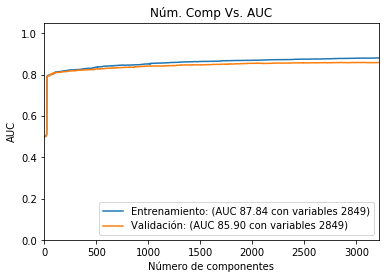

In [44]:
%matplotlib inline
plt.figure()
plt.plot(array_lr[:,0], array_lr[:,2],label='Entrenamiento: (AUC {0:.2f}'.format(array_lr[df_return-1,2]*100)+' con variables {0:.0f}'.format(array_lr[df_return-1,0])+')')
plt.plot(array_lr[:,0], array_lr[:,1],label='Validación: (AUC {0:.2f}'.format(array_lr[df_return-1,1]*100)+' con variables {0:.0f}'.format(array_lr[df_return-1,0])+')')
#plt.plot([0, 1586.0], [0, 1],'r--')
plt.xlim([0.0, 3216.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Número de componentes')
plt.ylabel('AUC')
plt.title('Núm. Comp Vs. AUC')
plt.legend(loc="lower right")
plt.savefig('LR_Vars_PCA')
plt.show()

In [45]:
X_train_t=X_train_n[X_train_n.columns[0:df_return]]
X_test_t =X_test_n[X_test_n.columns[0:df_return]]
logr = LogisticRegression(C=0.000001, random_state=9)
logr.fit(X_train_t, y_train)
lr_roc_auc=roc_auc_score(y_test, logr.predict(X_test_t))

In [ ]:
# save the model to disk
filename = 'finalized_model_pca_lr.sav'
pickle.dump(logr, open(filename, 'wb'))

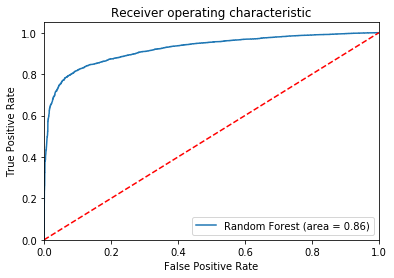

In [46]:
# ROC Logistic Reg
%matplotlib inline
#rf_roc_auc = roc_auc_score(y_test, logr.predict(X_test_t))
fpr, tpr, thresholds = roc_curve(y_test, logr.predict_proba(X_test_t)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('LR_ROC')
plt.show()

In [ ]:
empty_train_performance = create_dataset()
lr_performance = model_analysis(logr, X_train_t, y_train, X_test_t, y_test,empty_train_performance)
lr_performance

## Gradient boosting 

In [49]:
from tqdm import tqdm
getattr(tqdm, '_instances', {}).clear()  # ⬅ add this line

In [50]:
auc_f=0
idx = 0
dif=0.000005
random = [1,len(X_train_mod.columns)]
array_gb= np.empty((3216, 3))

for var in tqdm(range(len(X_train_mod.columns))):
    
    if var==0:
        X_train_t=X_train_n[X_train_n.columns[0:1]]
        X_test_t =X_test_n[X_test_n.columns[0:1]]
        gb_clf = GradientBoostingClassifier(learning_rate=0.2,max_depth=5, random_state=9)
        gb_clf.fit(X_train_t, y_train)
        rf_roc_auc=roc_auc_score(y_test, gb_clf.predict(X_test_t))
        rf_roc_auc_train=roc_auc_score(y_train, gb_clf.predict(X_train_t))
        vect_random=[1,rf_roc_auc,rf_roc_auc_train]
        array_gb = vect_random
    else:
        X_train_t=X_train_n[X_train_n.columns[0:var+1]]
        X_test_t =X_test_n[X_test_n.columns[0:var+1]]
        gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, max_features="sqrt", max_depth=5, random_state=9)
        gb_clf.fit(X_train_t, y_train)
        rf_roc_auc=roc_auc_score(y_test, gb_clf.predict(X_test_t))
        rf_roc_auc_train=roc_auc_score(y_train, gb_clf.predict(X_train_t))
        vect_random=[var+1,rf_roc_auc,rf_roc_auc_train]
 #       idx=var+1
        array_gb = np.vstack((array_gb,vect_random))
        
    if rf_roc_auc>auc_f:
        auc_f=rf_roc_auc
        idx=var+1
        if idx in [1,100,500,1000,1500]:
            print("Iteracion: ",idx)
    else:
        auc_f=auc_f
        idx=idx
        #break    # break here
        
    df_return = idx
print("Se necesitan: ", idx," variables")
print("Para tener: {0:.3f}".format(auc_f*100)," de AUC")

  0%|          | 0/3216 [00:00<?, ?it/s]

Iteracion:  1


100%|██████████| 3216/3216 [70:06:57<00:00, 78.49s/it]    


Se necesitan:  524  variables
Para tener: 85.138  de AUC


In [51]:
salvar_gb=pd.DataFrame(array_gb)
cols_array=['NumComp','AUC','AUC_train']
salvar_gb.columns=cols_array
salvar_gb.to_csv('array_gb_pca_02.csv')

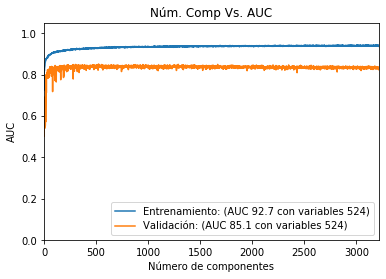

In [52]:
%matplotlib inline
plt.figure()
plt.plot(array_gb[:,0], array_gb[:,2],label='Entrenamiento: (AUC {0:.1f}'.format(array_gb[df_return-1,2]*100)+' con variables {0:.0f}'.format(array_gb[df_return-1,0])+')')
plt.plot(array_gb[:,0], array_gb[:,1],label='Validación: (AUC {0:.1f}'.format(array_gb[df_return-1,1]*100)+' con variables {0:.0f}'.format(array_gb[df_return-1,0])+')')

#plt.plot(array_gb[:,0], array_gb[:,1],label='Mayor: (AUC {0:.1f}'.format(0.8517*100)+' con variables {0:.0f}'.format(array_gb[df_return-1,0])+')')

#plt.plot([0, 1586.0], [0, 1],'r--')
plt.xlim([0.0, 3217])
plt.ylim([0.0, 1.05])
plt.xlabel('Número de componentes')
plt.ylabel('AUC')
plt.title('Núm. Comp Vs. AUC')
plt.legend(loc="lower right")
plt.savefig('GB_PCA')
plt.show()

In [53]:
X_train_t=X_train_n[X_train_n.columns[0:df_return]]
X_test_t =X_test_n[X_test_n.columns[0:df_return]]
gb_clf = GradientBoostingClassifier(n_estimators=100,learning_rate=0.2,max_features="sqrt", max_depth=5, random_state=9)
gb_clf.fit(X_train_t, y_train)
gb_roc_auc=roc_auc_score(y_test, gb_clf.predict(X_test_t))

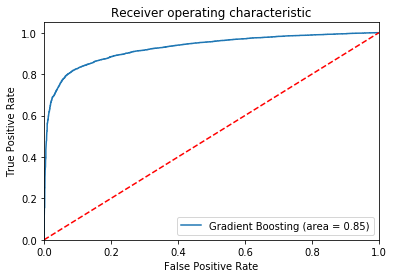

In [54]:
# ROC GB
%matplotlib inline
#rf_roc_auc = roc_auc_score(y_test, gb_clf.predict(X_test_t))
fpr, tpr, thresholds = roc_curve(y_test, gb_clf.predict_proba(X_test_t)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gradient Boosting (area = %0.2f)' % gb_roc_auc)
#plt.plot(fpr, tpr, label='Random Forest (area = %2.1f)' % (gb_roc_auc*100))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('GB_ROC_PCA')
plt.show()